In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sms.csv')

In [ ]:
"""
SMS Multi-Model Classifier
-------------------------
Trains and evaluates multiple algorithms (SVM, Random Forest, Naive Bayes, Logistic Regression,
KNN, MLP, a simple Keras Neural Network, and optional Transformer-based models including FLAN-T5
zero-shot classification and DistilBERT fine-tuning) on an SMS dataset with columns:

    Label, Messages

Usage (basic):
    python sms_multimodel_classifier.py --data path/to/dataset.csv

Key features:
- Clean & preprocess text
- Train/test split (stratified)
- TF‑IDF + classical ML models
- Metrics: accuracy, precision, recall, F1 (macro & weighted), confusion matrix
- Saves trained sklearn models and vectorizer
- Optional: Keras NN (Embedding-based) and Transformers (FLAN‑T5 zero-shot, DistilBERT fine-tuning)

Note:
- Transformers/keras parts require `transformers`, `torch`, and `tensorflow` installed respectively.
- Large models may require a GPU.
"""

import argparse
import os
import re
import random
import json
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

# Classical models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import joblib

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

############################################################
# Utils
############################################################

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    # Normalize weird encodings like '√Ç¬£' to '£' where possible
    s = s.encode("utf-8", "ignore").decode("utf-8", "ignore")
    # Lowercase
    s = s.lower()
    # Replace urls, numbers, phones with tokens
    s = re.sub(r"https?://\S+|www\.\S+", " <URL> ", s)
    s = re.sub(r"\b\d{3,}[- ]?\d{3,}\b", " <PHONE> ", s)
    s = re.sub(r"\b\d+\b", " <NUM> ", s)
    # Keep basic punctuation, remove other symbols
    s = re.sub(r"[^a-z0-9@#\$%\&'\-_/.:,!?\s<>]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalize column names
    cols = {c.lower().strip(): c for c in df.columns}
    label_col = cols.get('label') or 'Label'
    text_col = cols.get('messages') or 'Messages'
    # Standardize
    df = df.rename(columns={label_col: 'Label', text_col: 'Messages'})
    # Drop NA
    df = df.dropna(subset=['Label', 'Messages']).copy()
    df['Messages'] = df['Messages'].astype(str).apply(clean_text)
    df['Label'] = df['Label'].astype(str).str.strip()
    return df[['Label', 'Messages']]


@dataclass
class TrainConfig:
    test_size: float = 0.2
    val_size: float = 0.0  # unused for classical models
    max_features: int = 30000
    ngram_range: tuple = (1, 2)
    min_df: int = 2
    max_df: float = 0.95


def get_vectorizer(cfg: TrainConfig) -> TfidfVectorizer:
    return TfidfVectorizer(
        max_features=cfg.max_features,
        ngram_range=cfg.ngram_range,
        min_df=cfg.min_df,
        max_df=cfg.max_df,
        sublinear_tf=True,
        strip_accents='unicode'
    )


def compute_weights(y: np.ndarray) -> dict:
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    return {c: w for c, w in zip(classes, weights)}


############################################################
# Model zoo (classical)
############################################################

def build_models(class_weights: dict) -> dict:
    # For algorithms that can't take class_weight directly, we proceed without
    # (class imbalance is partly handled by TF‑IDF + evaluation metrics)
    return {
        'SVM_LinearSVC': LinearSVC(class_weight=class_weights, random_state=SEED),
        'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=SEED),
        'NaiveBayes_Multinomial': MultinomialNB(alpha=0.5),
        'LogisticRegression': LogisticRegression(max_iter=500, n_jobs=-1, class_weight=class_weights, solver='liblinear'),
        'KNN_5': KNeighborsClassifier(n_neighbors=5, n_jobs=None),
        'MLP_Classifier': MLPClassifier(hidden_layer_sizes=(256, 64), activation='relu', solver='adam', alpha=1e-4, batch_size=64, max_iter=20, random_state=SEED)
    }


def evaluate_predictions(y_true, y_pred) -> dict:
    acc = accuracy_score(y_true, y_pred)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'accuracy': acc,
        'precision_weighted': p_w,
        'recall_weighted': r_w,
        'f1_weighted': f1_w,
        'precision_macro': p_m,
        'recall_macro': r_m,
        'f1_macro': f1_m,
        'confusion_matrix': cm.tolist(),
        'report': classification_report(y_true, y_pred, zero_division=0)
    }


############################################################
# Optional: Keras simple NN
############################################################

def train_keras_nn(X_train, y_train, X_test, y_test, labels, out_dir: str):
    try:
        import tensorflow as tf
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        from tensorflow.keras import layers, models
    except Exception as e:
        print("[Keras] Skipping: TensorFlow not installed.")
        return None

    num_words = 20000
    maxlen = 100

    tok = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tok.fit_on_texts(X_train)
    X_tr = tok.texts_to_sequences(X_train)
    X_te = tok.texts_to_sequences(X_test)
    X_tr = pad_sequences(X_tr, maxlen=maxlen, padding='post', truncating='post')
    X_te = pad_sequences(X_te, maxlen=maxlen, padding='post', truncating='post')

    le = LabelEncoder()
    y_tr = le.fit_transform(y_train)
    y_te = le.transform(y_test)
    num_classes = len(le.classes_)

    model = models.Sequential([
        layers.Embedding(num_words, 128, input_length=maxlen),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    hist = model.fit(X_tr, y_tr, validation_split=0.1, epochs=15, batch_size=64, callbacks=[es], verbose=1)

    test_loss, test_acc = model.evaluate(X_te, y_te, verbose=0)
    y_pred = np.argmax(model.predict(X_te, verbose=0), axis=1)
    report = classification_report(y_te, y_pred, target_names=list(le.classes_), zero_division=0)

    os.makedirs(out_dir, exist_ok=True)
    model.save(os.path.join(out_dir, 'keras_nn.h5'))
    with open(os.path.join(out_dir, 'keras_nn.labels.json'), 'w') as f:
        json.dump(list(le.classes_), f, indent=2)
    with open(os.path.join(out_dir, 'keras_nn.tokenizer.json'), 'w') as f:
        f.write(tok.to_json())

    print("[Keras NN] Test accuracy:", test_acc)
    print("[Keras NN] Classification report:\n", report)


############################################################
# Optional: Transformers
############################################################

def zero_shot_flan_t5(texts, candidate_labels):
    """Zero-shot classification using FLAN‑T5 by prompting.
    NOTE: This is not fine-tuning; it's prompt-based and may be slower.
    """
    try:
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
        import torch
    except Exception as e:
        print("[T5] Skipping: transformers/torch not installed.")
        return None

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_name = 'google/flan-t5-base'
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

    outputs = []
    for t in texts:
        prompt = (
            "Classify the SMS into one of the following labels: "
            f"{', '.join(candidate_labels)}.\n"
            f"SMS: {t}\nLabel:"
        )
        enc = tok(prompt, return_tensors='pt').to(device)
        gen = model.generate(**enc, max_new_tokens=4)
        pred = tok.decode(gen[0], skip_special_tokens=True).strip()
        outputs.append(pred)
    return outputs


def finetune_distilbert(train_texts, train_labels, eval_texts, eval_labels, label_list, out_dir):
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
        import torch
        from datasets import Dataset
    except Exception:
        print("[DistilBERT] Skipping: transformers/torch/datasets not installed.")
        return None

    model_name = 'distilbert-base-uncased'
    tok = AutoTokenizer.from_pretrained(model_name)

    def tok_fn(batch):
        return tok(batch['text'], truncation=True, padding=True, max_length=256)

    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    train_ds = Dataset.from_dict({'text': train_texts, 'label': [label2id[l] for l in train_labels]})
    eval_ds = Dataset.from_dict({'text': eval_texts, 'label': [label2id[l] for l in eval_labels]})

    train_ds = train_ds.map(tok_fn, batched=True)
    eval_ds = eval_ds.map(tok_fn, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_list), id2label=id2label, label2id=id2label
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss'
    )

    def compute_metrics(eval_pred):
        preds, labels = eval_pred
        preds = np.argmax(preds, axis=1)
        acc = accuracy_score(labels, preds)
        p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
        return {'accuracy': acc, 'macro_f1': f1, 'macro_precision': p, 'macro_recall': r}

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model(out_dir)
    print(f"[DistilBERT] Model saved to: {out_dir}")


############################################################
# Main
############################################################

def main(data_path: str, out_dir: str = 'models_out', run_keras: bool = False, run_t5_zeroshot: bool = False, run_distilbert: bool = False):
    os.makedirs(out_dir, exist_ok=True)

    print('[*] Loading data...')
    df = load_data(data_path)
    print(df.head())

    labels = sorted(df['Label'].unique().tolist())
    print('[*] Labels:', labels)

    X = df['Messages'].values
    y = df['Label'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    class_weights = compute_weights(y_train)
    print('[*] Class weights:', class_weights)

    vectorizer = get_vectorizer(TrainConfig())

    # Build and evaluate classical models
    models = build_models(class_weights)
    results = {}

    for name, clf in models.items():
        print(f"\n[***] Training {name} ...")
        pipe = Pipeline([
            ('tfidf', vectorizer),
            ('clf', clf)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        metrics = evaluate_predictions(y_test, y_pred)
        results[name] = metrics
        # Save pipeline
        joblib.dump(pipe, os.path.join(out_dir, f'{name}.joblib'))
        print(f"[***] {name} metrics:")
        print(json.dumps({k: v for k, v in metrics.items() if k != 'report' and k != 'confusion_matrix'}, indent=2))
        print(metrics['report'])

def plot_confusion_matrix(cm, classes, model_name, out_dir):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'{model_name}_confusion_matrix.png'))
    plt.close()

def plot_precision_recall(y_true, y_scores, model_name, out_dir):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.savefig(os.path.join(out_dir, f'{model_name}_precision_recall.png'))
    plt.close()

def plot_class_distribution(labels, out_dir):
    plt.figure()
    sns.countplot(x=labels)
    plt.title('Class Distribution')
    plt.savefig(os.path.join(out_dir, 'class_distribution.png'))
    plt.close()

def plot_feature_importance(vectorizer, model, model_name, out_dir, top_n=20):
    if hasattr(model, 'coef_'):
        feature_names = np.array(vectorizer.get_feature_names_out())
        coefs = model.coef_[0]
        top_positive_coefficients = np.argsort(coefs)[-top_n:]
        top_negative_coefficients = np.argsort(coefs)[:top_n]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
        plt.figure(figsize=(10, 5))
        colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
        plt.bar(np.arange(2 * top_n), coefs[top_coefficients], color=colors)
        plt.xticks(np.arange(0, 2 * top_n), feature_names[top_coefficients], rotation=60, ha='right')
        plt.title(f'Top {top_n} Features - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f'{model_name}_feature_importance.png'))
        plt.close()




    # Save summary
    with open(os.path.join(out_dir, 'summary_metrics.json'), 'w') as f:
        json.dump(results, f, indent=2)

    # Optional: Keras NN
    if run_keras:
        print("\n[***] Training Keras simple NN ...")
        train_keras_nn(X_train, y_train, X_test, y_test, labels, os.path.join(out_dir, 'keras_nn'))

    # Optional: FLAN‑T5 zero-shot (prompt-based)
    if run_t5_zeroshot:
        print("\n[***] Running FLAN‑T5 zero-shot on test set ...")
        preds = zero_shot_flan_t5(list(X_test), labels)
        if preds is not None:
            # Map raw generations to closest known label by simple normalization
            norm = {l.lower(): l for l in labels}
            mapped = []
            for p in preds:
                p_norm = re.sub(r"[^a-z]", "", p.lower())
                best = None
                for l in labels:
                    l_norm = re.sub(r"[^a-z]", "", l.lower())
                    if p_norm.startswith(l_norm) or l_norm.startswith(p_norm):
                        best = l
                        break
                mapped.append(best or labels[0])  # fallback
            print(classification_report(y_test, mapped, zero_division=0))

    # Optional: DistilBERT fine-tuning
    if run_distilbert:
        print("\n[***] Fine-tuning DistilBERT ...")
        finetune_distilbert(list(X_train), list(y_train), list(X_test), list(y_test), labels, os.path.join(out_dir, 'distilbert'))

    print(f"\nAll done. Models saved under: {out_dir}")


# Removed argparse and directly call main with the data path
data_file_path = '/content/drive/MyDrive/Colab Notebooks/sms.csv'
main(data_file_path)

[*] Loading data...
   Label                                           Messages
0  fraud  telenor customer your prize is < > lakh < > bi...
1  fraud  dear telenor customer, your prize is out. for ...
2  fraud  < > from benazir program congratulations. for ...
3  fraud  < > from benazir program congratulations., ple...
4  fraud  in the ary jeeto pakistan show, your number < ...
[*] Labels: ['Normal', 'Promotional', 'fraud']
[*] Class weights: {'Normal': np.float64(0.6242878977351675), 'Promotional': np.float64(1.2490964692799555), 'fraud': np.float64(1.6733705772811918)}

[***] Training SVM_LinearSVC ...
[***] SVM_LinearSVC metrics:
{
  "accuracy": 0.9857651245551602,
  "precision_weighted": 0.9857291794347225,
  "recall_weighted": 0.9857651245551602,
  "f1_weighted": 0.9857253013391865,
  "precision_macro": 0.9835897426908434,
  "recall_macro": 0.980515873015873,
  "f1_macro": 0.9820308124549402
}
              precision    recall  f1-score   support

      Normal       0.99      1.00 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[***] LogisticRegression metrics:
{
  "accuracy": 0.9804270462633452,
  "precision_weighted": 0.9804824958909913,
  "recall_weighted": 0.9804270462633452,
  "f1_weighted": 0.9803408935468139,
  "precision_macro": 0.9815441650548035,
  "recall_macro": 0.9725198412698414,
  "f1_macro": 0.976889910855984
}
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       600
 Promotional       0.98      0.97      0.97       300
       fraud       0.99      0.95      0.97       224

    accuracy                           0.98      1124
   macro avg       0.98      0.97      0.98      1124
weighted avg       0.98      0.98      0.98      1124


[***] Training KNN_5 ...
[***] KNN_5 metrics:
{
  "accuracy": 0.9804270462633452,
  "precision_weighted": 0.9805371774750765,
  "recall_weighted": 0.9804270462633452,
  "f1_weighted": 0.9803126753902502,
  "precision_macro": 0.9804901086409639,
  "recall_macro": 0.9729166666666668,
  "f1_macro": 0.97652925034819

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


[***] MLP_Classifier metrics:
{
  "accuracy": 0.9848754448398577,
  "precision_weighted": 0.9848427794846617,
  "recall_weighted": 0.9848754448398577,
  "f1_weighted": 0.9848382403703269,
  "precision_macro": 0.9833986587889614,
  "recall_macro": 0.9795833333333334,
  "f1_macro": 0.9814668826569655
}
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       600
 Promotional       0.98      0.97      0.98       300
       fraud       0.98      0.97      0.98       224

    accuracy                           0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124



/tmp/ipython-input-200609889.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Label', palette='viridis')


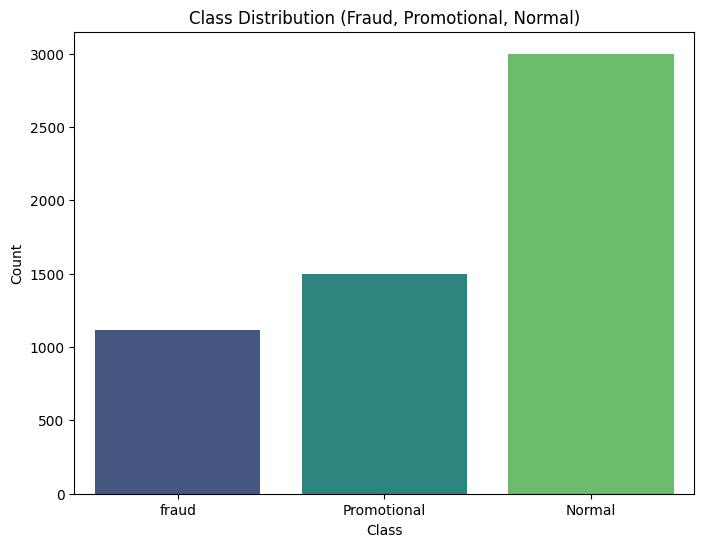

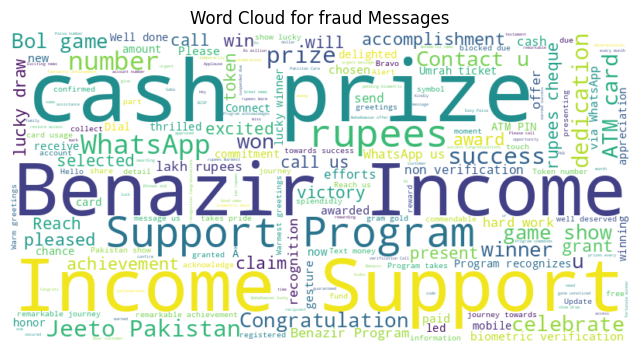

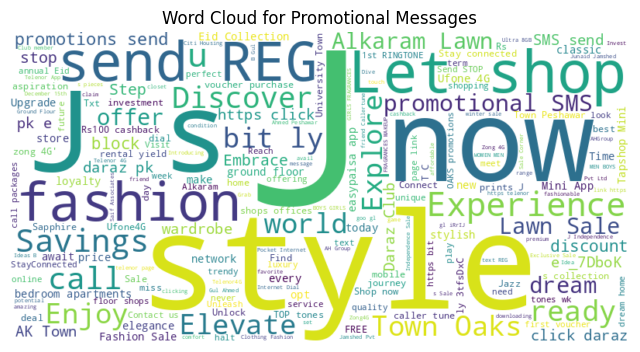

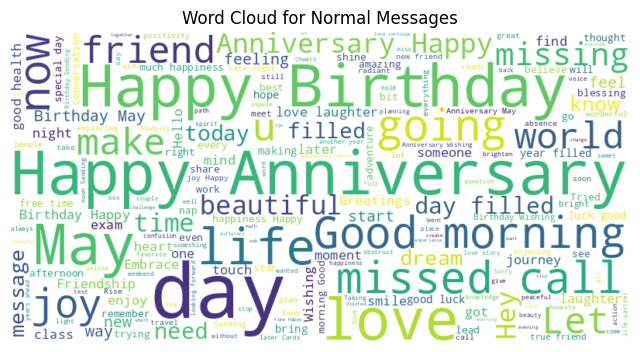

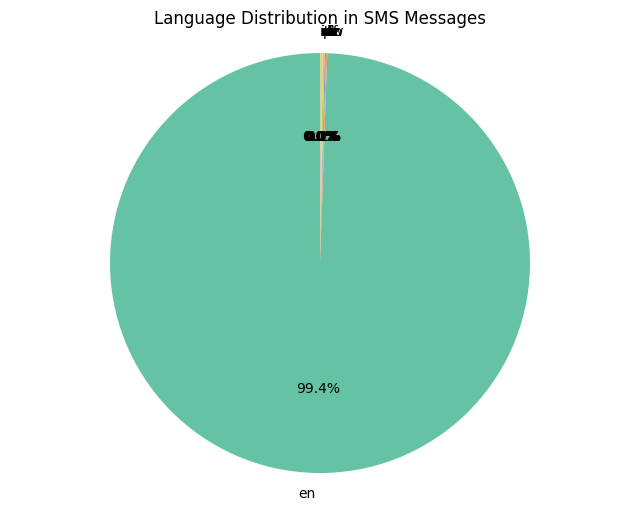

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from langdetect import detect
from collections import Counter

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sms.csv')

# Visualization 1: Class Distribution Bar Chart
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Label', palette='viridis')
plt.title('Class Distribution (Fraud, Promotional, Normal)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualization 2: Word Cloud per Class
# Creating word clouds for each class
classes = df['Label'].unique()

for cls in classes:
    plt.figure(figsize=(8, 6))
    text = ' '.join(df[df['Label'] == cls]['Messages'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {cls} Messages')
    plt.axis('off')
    plt.show()

# Visualization 3: Language Mix Pie Chart
# Detecting language of each message and calculating mix
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

df['Language'] = df['Messages'].apply(detect_language)
language_counts = Counter(df['Language'])

# Create pie chart for language distribution
plt.figure(figsize=(8, 6))
plt.pie(language_counts.values(), labels=language_counts.keys(), autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(language_counts)))
plt.title('Language Distribution in SMS Messages')
plt.axis('equal')
plt.show()


In [ ]:
import pandas as pd

# Load dataset


# Basic Statistical Information
# 1. Number of records
num_records = len(df)

# 2. Class Distribution
class_distribution = df['Label'].value_counts()

# 3. Average Message Length per Class
df['Message Length'] = df['Messages'].apply(len)
avg_length_per_class = df.groupby('Label')['Message Length'].mean()

# 4. Maximum and Minimum Message Length per Class
max_length_per_class = df.groupby('Label')['Message Length'].max()
min_length_per_class = df.groupby('Label')['Message Length'].min()

# 5. Total Number of Words per Message
df['Num Words'] = df['Messages'].apply(lambda x: len(x.split()))
avg_words_per_class = df.groupby('Label')['Num Words'].mean()

# 6. Message Length Distribution (overall)
message_length_stats = df['Message Length'].describe()

# 7. Number of Unique Words
unique_words = len(set(' '.join(df['Messages']).split()))

# Print the basic statistics
print(f"Number of Records: {num_records}")
print(f"Class Distribution:\n{class_distribution}\n")
print(f"Average Message Length per Class:\n{avg_length_per_class}\n")
print(f"Maximum Message Length per Class:\n{max_length_per_class}\n")
print(f"Minimum Message Length per Class:\n{min_length_per_class}\n")
print(f"Average Number of Words per Message by Class:\n{avg_words_per_class}\n")
print(f"Message Length Distribution (Overall):\n{message_length_stats}\n")
print(f"Number of Unique Words in Dataset: {unique_words}")


Number of Records: 5617
Class Distribution:
Label
Normal         2999
Promotional    1499
fraud          1119
Name: count, dtype: int64

Average Message Length per Class:
Label
Normal          78.901967
Promotional    142.432955
fraud          146.276139
Name: Message Length, dtype: float64

Maximum Message Length per Class:
Label
Normal         289
Promotional    582
fraud          322
Name: Message Length, dtype: int64

Minimum Message Length per Class:
Label
Normal         12
Promotional    30
fraud          48
Name: Message Length, dtype: int64

Average Number of Words per Message by Class:
Label
Normal         13.458153
Promotional    22.394263
fraud          24.142985
Name: Num Words, dtype: float64

Message Length Distribution (Overall):
count    5617.000000
mean      109.278440
std        51.016904
min        12.000000
25%        70.000000
50%        97.000000
75%       142.000000
max       582.000000
Name: Message Length, dtype: float64

Number of Unique Words in Dataset: 1262

In [ ]:
%pip install langdetect wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=1e03bb05b6eea18047455628c36ac396f3908feb822ec62017b8838a851942b3
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
